In [1]:
import autograd.numpy as np
from autograd import jacobian
from numpy import genfromtxt
import scipy
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa I_1 + (1-3\kappa)I_4$ and $\mathbf{E} = [\mathbf{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [2]:
def GOH_P(par,lam1,lam2):
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    
    #Structure tensor
    a0 = np.array([np.cos(alpha),np.sin(alpha),0])
    M = np.outer(a0,a0)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
    C = F.T*F
    invF = np.linalg.inv(F)
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4 = np.tensordot(C,M)
    
    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*np.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*M)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2

    P =  F*S
    return P

In [3]:
def MR_P(par, lm1, lm2):
    C10 = par[0]
    C01 = par[1]
    C20 = par[2]
    lm3 = 1/(lm1*lm2)
    sigma1 = 2*(C10*(lm1**2 - lm3**2) - C01*(1/lm1**2 - 1/lm3**2) +
              2*C20*(lm1**2 - lm3**2)*(lm1**2 + lm2**2 + lm3**2 - 3))
    sigma2 = 2*(C10*(lm2**2 - lm3**2) - C01*(1/lm2**2 - 1/lm3**2) +
              2*C20*(lm2**2 - lm3**2)*(lm1**2 + lm2**2 + lm3**2 - 3))
    sigma = [[(sigma1), 0, 0], [0, (sigma1), 0], [0, 0, 0]]
    F = np.array([[(lm1) ,0., 0],[0.,(lm2), 0] ,[0., 0,(lm3)]])
    FinvT = np.linalg.inv(F).T
    P = sigma*FinvT
    return P

In [4]:
def HGO_P(par,lam1,lam2):
    C10 = par[0]
    k1 = par[1]
    k2 = par[2]
    alpha = par[3] #Assume the fibers are orthogonal to each other
    
    #Structure tensor
    v0 = np.array([np.cos(alpha), np.sin(alpha), 0])
    w0 = np.array([np.cos(alpha),-np.sin(alpha), 0])
    V0 = np.outer(v0,v0)
    W0 = np.outer(w0,w0)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
    C = F.T*F
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4 = np.tensordot(C,V0)
    I6 = np.tensordot(C,W0)
    
    Psi1 = C10
    Psi4 = k1*(I4-1)*np.exp(k2*(I4-1)**2)
    Psi6 = k1*(I6-1)*np.exp(k2*(I6-1)**2)
    
    S2 = 2*Psi1*I + 2*Psi4*V0 + 2*Psi6*W0
    p = S2[2,2]/invC[2,2]
    S = S2 - p*invC

    P =  F*S
    return P

In [5]:
def Fung_P(par, lam1, lam2):
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
    C = F.T*F
    E_11 = 0.5*(C[0,0]-1)
    E_22 = 0.5*(C[1,1]-1)
    E_Z = E_11
    E_theta = E_22
    
    C  = par[0]
    a1 = par[1]
    a2 = par[2]
    a4 = par[3]
    
    Q = a1*E_theta**2 + a2*E_Z**2 + 2*a4*E_theta*E_Z
    S_theta = C*(a1*E_theta + a4*E_Z)*np.exp(Q)
    S_Z     = C*(a4*E_theta + a2*E_Z)*np.exp(Q)
    S = [[(S_theta), 0, 0], [0, (S_Z), 0], [0, 0, 0]]
    P = F*S
    return P

In [62]:
def neoHook_P(par, lam1, lam2):
    C1 = par[0]
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
    C = F.T*F
    invC = np.linalg.inv(C)
    
    I = np.eye(3)
    p = 2*C1*C[2,2]
    S = 2*C1*I - p*invC
    P = F*S
    return P

# Import all relevant data and form data frames

Visualize data here to insepct. Correct the files before proceeding to fitting

In [64]:
Exp = "P1C1"
A_Offx = Exp+"S1_OffX.csv"
A_Offy = Exp+"S1_OffY.csv"

In [65]:
AX = genfromtxt(A_Offx,delimiter=',')
AY = genfromtxt(A_Offy,delimiter=',')
A = np.vstack([AX,AY])

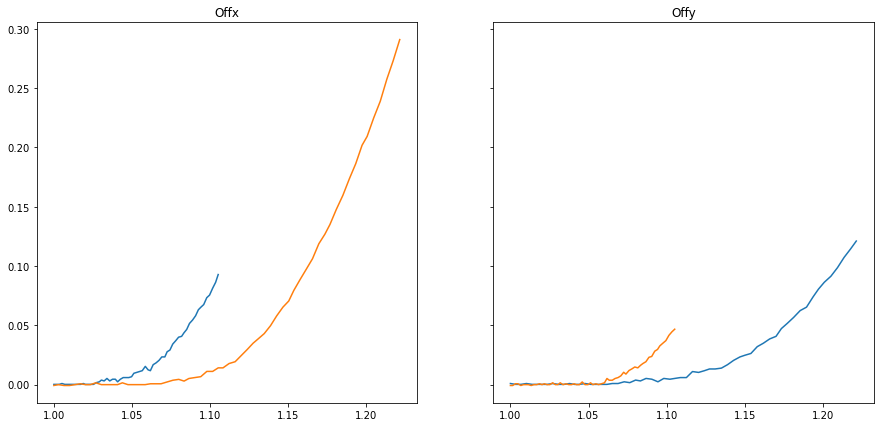

In [66]:
fig,ax = plt.subplots(1,2,figsize=(15,7),sharey=True)
ax[0].plot(AX[:,0],AX[:,1])
ax[0].plot(AX[:,2],AX[:,3])
ax[0].set_title("Offx")
ax[1].plot(AY[:,0],AY[:,1])
ax[1].plot(AY[:,2],AY[:,3])
ax[1].set_title("Offy")
plt.show()

## Objective function for fitting 

In [67]:
def Obj_GOH(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = GOH_P(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jac_GOH = jacobian(Obj_GOH) # Jacobian of the objctive function using Autograd

def Obj_MR(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = MR_P(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jac_MR = jacobian(Obj_MR) # Jacobian of the objctive function using Autograd

def Obj_HGO(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = HGO_P(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jac_HGO = jacobian(Obj_HGO) # Jacobian of the objctive function using Autograd

def Obj_Fung(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = Fung_P(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jac_Fung = jacobian(Obj_Fung) # Jacobian of the objctive function using Autograd

def Obj_neoHook(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = neoHook_P(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jac_neoHook = jacobian(Obj_neoHook) # Jacobian of the objctive function using Autograd

### Run the optimizer and inspect the results

In [71]:
par = [9.86876414e-04, 5.64353050e-01, 7.95242698e+01, 2.94747207e-01, 1.57079633e+00]
bounds = Bounds([0.0,0.0,0.0,0.,-np.pi/2],[10.,10.,1000.,1/3,np.pi/2] ) #Bounds on parameters
opt_GOH = scipy.optimize.minimize(Obj_GOH,par,jac=jac_GOH,bounds = bounds)
print("GOH Parameters: ",opt_GOH.x)

par = [0.,         0.,         0.14424528]
bounds = Bounds([0.0,0.0,0.0],[10.,10.,10.] )
opt_MR = scipy.optimize.minimize(Obj_MR,par,jac=jac_MR,bounds = bounds)
print("Mooney Rivlin Parameters: ",opt_MR.x)

par = [0.02646892, 0.01028124, 10.00000681,  1.57078588]
bounds = Bounds([0,0,0,-np.pi/2],[10,10,100,np.pi/2])
opt_HGO = scipy.optimize.minimize(Obj_HGO,par, method='Nelder-Mead')#,jac=jac_HGO,bounds = bounds)
print("HGO Parameters: ",opt_HGO.x)

par = [2, 3, 1, 0.5]
bounds = Bounds([0,0,0,0],[10,100,10,100])
opt_Fung = scipy.optimize.minimize(Obj_Fung,par,method='Nelder-Mead')#,jac=jac_Fung,bounds = bounds)
print("Fung Parameters: ",opt_Fung.x)

par = 0.04902344
opt_neoHook = scipy.optimize.minimize(Obj_neoHook,par,method='Nelder-Mead')#,jac=jac_Fung,bounds = bounds)
print("Neo Hookean Parameters: ",opt_neoHook.x)

GOH Parameters:  [9.05131836e-03 5.64896465e-01 7.95242636e+01 2.87810959e-01
 1.57079633e+00]
Mooney Rivlin Parameters:  [0.         0.         0.14424528]
HGO Parameters:  [1.29024967e-02 1.72417317e-02 1.40044269e+01 2.11021066e+00]
Fung Parameters:  [ 2.41472813e-03 -1.74859889e+00 -2.14539464e+01  4.98435759e+01]
Neo Hookean Parameters:  [0.04902344]


#### Plot results

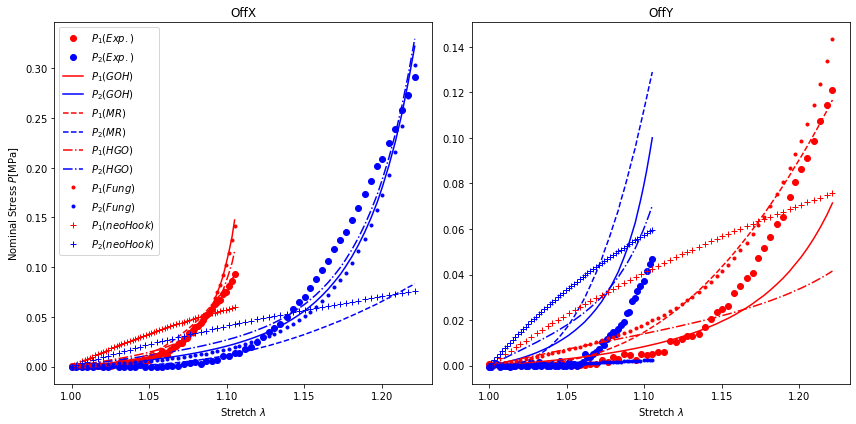

In [69]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

lam1_1 = AX[:,0]
lam1_2 = AX[:,2]
PE1_1 = AX[:,1]
PE1_2 = AX[:,3]
P_GOH_1 = np.zeros([len(lam1_1),2])
P_MR_1 = np.zeros([len(lam1_1),2])
P_HGO_1 = np.zeros([len(lam1_1),2])
P_Fung_1 = np.zeros([len(lam1_1),2])
P_neoHook_1 = np.zeros([len(lam1_1),2])
for i in range(0,len(lam1_1)):
    P_GOH = GOH_P(opt_GOH.x,lam1_1[i],lam1_2[i])
    P_MR = MR_P(opt_MR.x,lam1_1[i],lam1_2[i])
    P_HGO = HGO_P(opt_HGO.x,lam1_1[i],lam1_2[i])
    P_Fung = Fung_P(opt_Fung.x,lam1_1[i],lam1_2[i])
    P_neoHook = neoHook_P(opt_neoHook.x,lam1_1[i],lam1_2[i])
    P_GOH_1[i,0] = P_GOH[0,0]
    P_GOH_1[i,1] = P_GOH[1,1]
    P_MR_1[i,0] = P_MR[0,0]
    P_MR_1[i,1] = P_MR[1,1]
    P_HGO_1[i,0] = P_HGO[0,0]
    P_HGO_1[i,1] = P_HGO[1,1]
    P_Fung_1[i,0] = P_Fung[0,0]
    P_Fung_1[i,1] = P_Fung[1,1]
    P_neoHook_1[i,0] = P_neoHook[0,0]
    P_neoHook_1[i,1] = P_neoHook[1,1]
        
lam2_1 = AY[:,0]
lam2_2 = AY[:,2]
PE2_1 = AY[:,1]
PE2_2 = AY[:,3]
P_GOH_2 = np.zeros([len(lam2_1),2])
P_MR_2 = np.zeros([len(lam2_1),2])
P_HGO_2 = np.zeros([len(lam2_1),2])
P_Fung_2 = np.zeros([len(lam2_1),2])
P_neoHook_2 = np.zeros([len(lam2_1),2])
for i in range(0,len(lam2_1)):
    P_GOH = GOH_P(opt_GOH.x,lam2_1[i],lam2_2[i])
    P_MR = MR_P(opt_MR.x,lam2_1[i],lam2_2[i])
    P_HGO = HGO_P(opt_HGO.x,lam2_1[i],lam2_2[i])
    P_Fung = Fung_P(opt_Fung.x,lam2_1[i],lam2_2[i])
    P_neoHook = neoHook_P(opt_neoHook.x,lam2_1[i],lam2_2[i])
    P_GOH_2[i,0] = P_GOH[0,0]
    P_GOH_2[i,1] = P_GOH[1,1]
    P_MR_2[i,0] = P_MR[0,0]
    P_MR_2[i,1] = P_MR[1,1]
    P_HGO_2[i,0] = P_HGO[0,0]
    P_HGO_2[i,1] = P_HGO[1,1]
    P_Fung_2[i,0] = P_Fung[0,0]
    P_Fung_2[i,1] = P_Fung[1,1]
    P_neoHook_2[i,0] = P_neoHook[0,0]
    P_neoHook_2[i,1] = P_neoHook[1,1]
        
ax[0].plot(lam1_1,PE1_1,'o',color='r',label=r'$P_1 (Exp.)$')
ax[0].plot(lam1_2,PE1_2,'o',color='b',label=r'$P_2 (Exp.)$')            
ax[0].plot(lam1_1,P_GOH_1[:,0],'-',color='r', label='$P_1 (GOH)$') 
ax[0].plot(lam1_2,P_GOH_1[:,1],'-',color='b', label='$P_2 (GOH)$')
ax[0].plot(lam1_1,P_MR_1[:,0],'--',color='r', label='$P_1 (MR)$') 
ax[0].plot(lam1_2,P_MR_1[:,1],'--',color='b', label='$P_2 (MR)$') 
ax[0].plot(lam1_1,P_HGO_1[:,0],'-.',color='r', label='$P_1 (HGO)$') 
ax[0].plot(lam1_2,P_HGO_1[:,1],'-.',color='b', label='$P_2 (HGO)$') 
ax[0].plot(lam1_1,P_Fung_1[:,0],'.',color='r', label='$P_1 (Fung)$') 
ax[0].plot(lam1_2,P_Fung_1[:,1],'.',color='b', label='$P_2 (Fung)$') 
ax[0].plot(lam1_1,P_neoHook_1[:,0],'+',color='r', label='$P_1 (neoHook)$') 
ax[0].plot(lam1_2,P_neoHook_1[:,1],'+',color='b', label='$P_2 (neoHook)$') 
ax[0].set_title("OffX")
ax[0].set_xlabel(r'Stretch $\lambda$')
ax[0].set_ylabel(r'Nominal Stress $P$[MPa]')
ax[0].legend()

ax[1].plot(lam2_1,PE2_1,'o',color='r',label=r'$P_1 (Exp.)$')  
ax[1].plot(lam2_2,PE2_2,'o',color='b',label=r'$P_2 (Exp.)$')        
ax[1].plot(lam2_1,P_GOH_2[:,0],'-',color='r', label='$P_1 (GOH)$')  
ax[1].plot(lam2_2,P_GOH_2[:,1],'-',color='b', label='$P_2 (GOH)$') 
ax[1].plot(lam2_1,P_MR_2[:,0],'--',color='r', label='$P_1 (MR)$')  
ax[1].plot(lam2_2,P_MR_2[:,1],'--',color='b', label='$P_2 (MR)$') 
ax[1].plot(lam2_1,P_HGO_2[:,0],'-.',color='r', label='$P_1 (HGO)$')   
ax[1].plot(lam2_2,P_HGO_2[:,1],'-.',color='b', label='$P_2 (HGO)$') 
ax[1].plot(lam2_1,P_Fung_2[:,0],'.',color='r', label='$P_1 (Fung)$')   
ax[1].plot(lam2_2,P_Fung_2[:,1],'.',color='b', label='$P_2 (Fung)$') 
ax[1].plot(lam2_1,P_neoHook_2[:,0],'+',color='r', label='$P_1 (neoHook)$')   
ax[1].plot(lam2_2,P_neoHook_2[:,1],'+',color='b', label='$P_2 (neoHook)$') 
ax[1].set_title("OffY")
ax[1].set_xlabel(r'Stretch $\lambda$')

plt.tight_layout()
plt.savefig("Img/"+Exp+".png",dpi=300)
plt.show()
